In [1]:
import numpy
import matplotlib.pyplot as plt

## Plotting phasor blobs

A bivariate gaussian blob can be interpreted as a set of complex numbers.

In the plot below, take the y axis to be the imaginary axis, and the x axis to be the real. Each of the points is a complex number. Also, each of them is a phasor representing a sinusoidal wave with a given amplitude and phase offset!

The upshot is that we can visualize a set of phasors as a blob like the below.

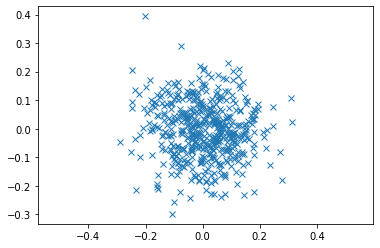

In [2]:
def complex_blob(n, scale=1.0):
    x, y = numpy.random.multivariate_normal([0, 0], [[scale ** 2, 0], [0, scale ** 2]], n).T
    return x + y * 1j

def plot_blob(c):
    plt.plot(c.real, c.imag, 'x')
    plt.axis('equal')
    plt.show()
    
plot_blob(complex_blob(500, scale=0.1))

## Perturbing blobs

To model the kind of "noise" that I think probably gets added to hathitrust volumes, when represented as semantic phasor embeddings, we can **randomly turn the blob by some amount**, and then also **add a bit of noise** to the position of each phasor.

These operations can themselves be done with more complex blobs! To rotate, we multiply all the phasors by a normalized complex number. To add noise, we add a relatively small complex number to each phasor.

Let's begin by creating a blob of 100 phasors.

In [3]:
start = complex_blob(100)

Now we do the above two operations. Inside the `perturb_blob` function, `offset` contains the rotated blobs. `noisy` has the same blobs with a bit of unique noise added to each one. We create 100 copies and plot the first two to show how these perturbations change the shape of the data.

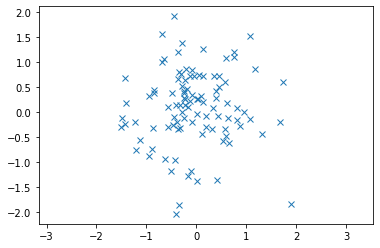

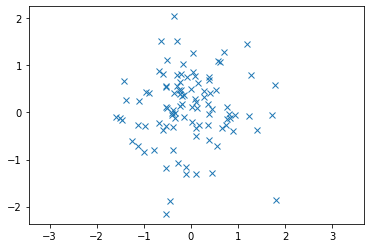

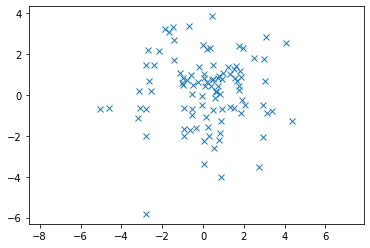

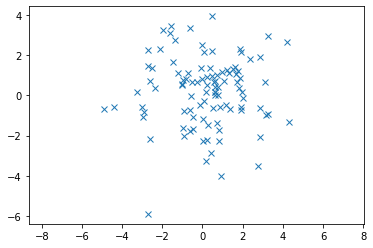

In [4]:
def perturb_blob(start, n=100):
    """Randomly rotate the starting blob and add a little bit of noise."""
    offset = [start * c / (c * c.conjugate()) for c in complex_blob(n)]
    noisy = [o + complex_blob(len(start), scale=0.1) for o in offset]
    return offset, noisy

offset, noisy = perturb_blob(start)

plot_blob(offset[0])
plot_blob(noisy[0])
plot_blob(offset[1])
plot_blob(noisy[1])

## Generating a distinctive signature for noisy blobs that came from the same starting point

Our goal is to generate a "signature" that will identify perturbed blobs that came from the same initial blob. These signatures will be vectors, and they should cluster together tightly when they correspond to blobs from the same starting point.

This entails figuring out a way to denoise the phasor blob and undo (or at least mask) the rotation. Since the noise being added is independently distributed, we can pick a random subset of noisy phasors and take the average. This will attenuate the noise, because the noise will tend to go in all directions, and on average, will cancel itself out. So in theory this average phasor will be very similar for blobs that came from the same starting point.

This also gives us a stable reference point for measuring relative rotation. We can't tell how much the blob was rotated, but given a stable reference point, we can measure the relative position of other phasors. So now, we chose another random subset of noisy phasors, and divide by the normalized value of the average phasor above. That gives us our signature!

Unfortunately...

In [5]:
def signature_fail_1(blob):
    cent = sum(blob[:10]) / 10
    cnorm = cent / (cent * cent.conjugate())
    return numpy.array([c / cnorm for c in blob[10:20]])

...it doesn't work. These signatures aren't close together at all.

In [6]:
signatures = [signature_fail_1(n) for n in noisy]
diff_mags = [(s * s.conjugate()).real
             for sig in signatures[1:] 
             for s in signatures[0] - sig]

print("Maximum difference beteween signature phasors:")
print(max(diff_mags))
print()
print("Average differene between signature phasors:")
print(numpy.mean(diff_mags))
print()
print('Yuck.')

Maximum difference beteween signature phasors:
6681.528022666208

Average differene between signature phasors:
14.368324681784172

Yuck.


The maximum difference between two signature phasors is enormous, and the average difference is also really big.

##  What has gone wrong? 

Let's consider this hypothesis: when the average phasor is based on a lot of points that are close to the origin, small absolute error terms can still cause extreme phase errors. This could even be happening when the points are far from the origin but distributed in a way that places the average near the origin. 

To test this hypothesis, let's see what happens if we pick phasors that are far way from the origin, and instead of taking their average directly, we just take the average of their phase. Here that means taking the geometric mean of their normalized values.

So let's sort the phasors by their magnitude and pick the largest. Because there's some noise, we might not always pick exactly the same phasors, but we can hope that the outliers will mostly be the same, and that the difference won't throw off the average too much.

In [7]:
def mag(c):
    return c * c.conjugate()

def norm(c):
    return c / mag(c)

def signature(blob):
    top10_mag = sorted(mag(c) for c in blob)[-10:]
    offset = numpy.prod(top10_mag) ** (1 / 10)
    return numpy.array([c / offset for c in blob[:10]])

This time it seems to work pretty well!

In [8]:
signatures = [signature(n) for n in noisy]
diff_mags = [(s * s.conjugate()).real
             for sig in signatures[1:] 
             for s in signatures[0] - sig]

print("Maximum difference beteween signature phasors:")
print(max(diff_mags))
print()
print("Average differene between signature phasors:")
print(numpy.mean(diff_mags))
print()
print('Yay!')

Maximum difference beteween signature phasors:
0.9408110218808953

Average differene between signature phasors:
0.07426861826803169

Yay!


So all that remains is to see whether the noise that gets added to hathitrust volumes is well modeled by this gaussian noise. If it is, then these signatures may be very effective for deduplicating text.